# 6. Metody oceny modelu klasyfikacji i strojenie parametryczne

Na poprzednich zajęciach ocenialiśmy działanie klasyfikatora wyznaczając średnią poprawność (_accuracy_) na wydzielonym zbiorze testowym. Miara poprawności nie daje jednak informacji o tym, które przypadki zostały źle sklasyfikowane i które klasy były ze sobą mylone. Może mieć to istotne znaczenie, gdy koszt popełnienia błędu predykcji dla jednej z klas jest większy od innych rodzajów błędów, np. błędny wynik pozytywny przy diagnozie choroby może mieć katastrofalnie większe konsekwencje niż błędny wynik negatywny. Wówczas klasyfikator o mniejszej poprawności może okazać się lepszy jeżeli tylko popełnia mniej błędów określonego typu. Również w przypadku niezrównoważonych liczebnie klas liczenie średniej poprawności nie jest najlepszą miarą. Przykładowo poprawność na poziomie 90% dla zbioru, w którym jedna z klas stanowi tylko 10% przypadków może oznaczać, że wszystkie przypadki z tej mało licznej klasy są niepoprawnie klasyfikowane. W takich sytuacjach rozważyć należy zastosowanie innych miar oceny modeli jak, np.: precyzja, pełność, czy miara F1. 

Dodatkowo, procedura strojenia parametrów modelu, zastosowana na poprzednich zajęciach, w której kolejne modele były wielokrotne oceniane na tym samym zbiorze testowym jest nadużyciem. Poprzez wielokrotne powtórzenie również sprawiamy, że dopasowujemy się pośrednio do danych testowych. Rozkład danych w zbiorze testowym zawiera losowość i będzie inny przy powtórnym podziale na część testową i treningową. Nie należy się spodziewać, że parametry dobrane dla modelu dla jednego wydzielonego zbioru testowego będą takie same, gdy wydzielimy podzbiór testowy składający się z innych przypadków. Rzetelna ocena poprawności modeli dla konkretnych danych wymaga więc ostrożności. Niniejszy notatnik przybliża metodę walidacji krzyżowej stosowaną do oceny jakości modeli klasyfikacji oraz do strojenia parametrów modeli. Przybliżone też zostaną miary oceny istotne w przypadku niezbalansowanych klas. 

## Dane Iris

Rozpocznijmy od wczytania danych. Zbiór Irys zawiera 150 przypadków opisujących w 4 zmiennych trzy gatunki Irysów. 

In [ ]:
from sklearn import datasets

iris = datasets.load_iris()

In [ ]:
import numpy as  np

print('Ilość przypadków: %d' % iris.data.shape[0])
print('Ilość zmiennych: %d' % iris.data.shape[1])
print('Ilość klas: %d' % len(iris.target_names))

print(iris.data[:10])
print(iris.target[:10])

for i, target_name in enumerate(iris.target_names):
    print('klasa %d, %s, liczebność : %d' % (i, target_name, np.sum(iris.target == i)))

Podzielmy zbiór na część testową oraz treningową w proporcji 70-30.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
            train_test_split(iris.data, iris.target, test_size=0.3, random_state=0)
    
print('Ilość przypadków treningowych %d' % X_train.shape[0])
print('Ilość przypadków testowych %d' % X_test.shape[0])

Zbudujmy model klasyfikacji w oparciu o drzewo decyzyjne.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=2)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)


## Martyki oceny skuteczności

Podstawową miarą oceny jakości klasyfikatora jest **poprawność** (_accuracy_). Na poprzednich zajęciach zdefiniowaliśmy funkcję `accuracy_score` do wyznaczania tej wartości. Tym razem skorzystajmy z gotowej funkcji dostępnej w `sklearn.metrics`.

In [ ]:
from sklearn.metrics import accuracy_score

print('Poprawność: %.3f' % accuracy_score(y_true=y_test, y_pred=y_pred))

Dane Irys zawierają 3 klasy a poprawność niewiele mówi o tym jak klasyfikator zachowuje się dla poszczególnych klas. Ze zbiorem Irys spotkaliśmy się już na poprzednich zajęciach. Jeżeli sporządzilibyśmy wykres rozrzutu to zobaczylibyśmy, że Setosa jest kwiatem, który znacznie różni się od pozostałych dwóch gatunków, a najwięcej problemów będzie sprawiało rozróżnienie Virginicy i Versicolor.

Aby zweryfikować, które klasy są ze sobą mylone użyjmy **macierzy pomyłek** (_confusion matrix_).

In [ ]:
from sklearn.metrics.classification import confusion_matrix

confmat = confusion_matrix(y_test, y_pred)

print(confmat)

Liczby w macierzy oznaczają ilości przypadków przypisanych przez model do poszczególnych klas w stosunku do prawdziwej przynależności. Poniżej znajduje się wizualizacja macierzy pomyłek, która ułatwi jej interpretację.


In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

ax.set_xticklabels([' '] + iris.target_names.tolist())
ax.yaxis.tick_right()
ax.set_yticklabels([' '] + iris.target_names.tolist())
        
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.show()

Wszystkie 16 przypadków Setosa zostało poprawnie zaklasyfikowanych, 3 przypadki Virginica, stanowiące 6% zbioru testowego, przypisanych zostało blednie do klasy Versicolor, zaś 1 przypadek Versicolor jest mylony z Virginicą. 

Poprawność (_accuracy_) możemy wyznaczyć bezpośrednio z macierzy pomyłek dzieląc sumę wartości leżących na diagonali przez liczbę wszystkich przypadków:

In [ ]:
acc = np.trace(confmat) / np.sum(confmat)
print('Poprawność: %.3f' % acc)

Więcej informacji o błędach popełnianych dla poszczególnych klas dają miary takie jak: precyzja (_precision/), pełność (_recall_), czy F1. Definiowane są one dla problemu binarnego, gdzie dane podzielone są na próbki pozytywne i negatywne. Miary te są przydatne, gdy liczebności klas są istotnie różne (tzw. dane niezbalansowane) oraz gdy jeden rodzaj błędu ma inna wagę od innych błędów, np. fałszywa odpowiedź pozytywna kontra fałszywa odpowiedź negatywa.

**Precyzja** (_precision_) jest miarą, która określa odsetek poprawnie klasyfikowanych przypadków z wybranej klasy (pozytywnej) w grupie wszystkich przypadków zaliczonych przez model do tej klasy. Możemy wyznaczyć tę wartość na podstawie macierzy pomyłek dla każdej z klas osobno. 

Obliczmy precyzję modelu dla klasy Virginica (target=2)

In [ ]:
positive_id = 2    # wybrana klasa Virginica
prec = confmat[positive_id, positive_id] / np.sum(confmat[:, positive_id])
print('Precyzja : %.3f' % prec)

Spośród 9 przypadków przypisanych do Virginica 8 prawdziwie należało to tej klasy.

Gdy precyzja wynosi 0 świadczy to o tym, że klasyfikator myli się za każdym razem dla przypadków ze wskazanej klasy, w przypadku precyzji równej 1 wszystkie pozytywne odpowiedzi modelu dla wskazanej klasy są poprawne.

**Pełność** (_recall_) określa odsetek poprawnie klasyfikowanych przypadków z wybranej klasy. 


In [ ]:
positive_id = 2
recall = confmat[positive_id, positive_id] / np.sum(confmat[positive_id, :])

print('Recall : %.3f' % recall)

Spośród 11 przypadków z klasy Virginica 8 zostało poprawnie sklasyfikowanych dając 0.727

Gdy `recall=0` wówczas żaden przypadek ze wskazanej klasy nie został popranie zaklasyfikowany.  

Zazwyczaj pożądamy aby zarówno precyzja oraz pełność miały jak największą wartość, wówczas uwzględnia się **miarę F1** (`F1-score`), która jest kombinacją precyzji i recall

$$F1 = 2 \frac{precision \times recall}{precission + recall}$$

In [ ]:
f1_score = 2 * (prec * recall) / (prec + recall) 
print('f1_score: %.3f' % f1_score)

Jeżeli jedna z miar, precyzja lub recall, jest równa 0 wówczas f1-score również wynosi 0. Maksymalna wartość 1 miara F1 otrzymuje, gdy precyzja i pełność też są równe 1.

Pakiet scikit-learn implementuje te miary w bibliotece `sklearn.metrics`. Są one wyznaczane dla wartości binarnych (klasyfikacja dwuklasowa), gdzie wartość wyjściowa 1 określa przypadki z wyróżnionej klasy (pozytywne), zaś wartość 0 oznacza wszystkie pozostałe klasy (przypadki negatywne).

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

positive_id = 2

print('Precision: %.3f' % precision_score(y_true=y_test == positive_id, y_pred=y_pred == positive_id))
print('Recall   : %.3f' % recall_score(y_true=y_test == positive_id, y_pred=y_pred == positive_id))
print('F1       : %.3f' % f1_score(y_true=y_test == positive_id, y_pred=y_pred == positive_id))


Funkcja `classification_report` wypisuje wszystkie te miary dla każdej z klas. 

In [ ]:
from  sklearn.metrics.classification import classification_report

print(classification_report(y_test, y_pred , target_names=iris.target_names))

Wartości `macro avg` to średnie wartości precyzji, recall i miary F1, z kolei `weighted avg` to średnie ważone miar, gdzie wagami są liczebności klas. 


Nasze drzewo decyzyjne myli się tylko dla 4 przypadków co stanowi aż 8% błędu na zbiorze testowym. Przy innym wylosowanym zbiorze testowym ten wynik mógłby wyglądać inaczej. Przy dostatecznie dużej liczbie powtórzeń moglibyśmy nawet trafić na sytuację, w której wszystkie przypadki ze zbioru testowego zostałyby poprawnie zaklasyfikowane. Taki pojedynczy wynik nie jest wiarygodny i może wynikać losowego charakteru całego procesu. Wiarygodną ocenę oszacowania wartości miar możemy uzyskać uśredniając wyniki uzyskane z wielokrotnego losowania zbioru testowego. Chcąc jednak zagwarantować aby każdy przypadek ze zbioru danych  przynajmniej raz znalazł się w zbiorze testowym stosuje się **walidację krzyżową**.



## Walidacja krzyżowa 


Walidacja krzyżowa (_cross validation_) polega na podziale zbioru na $k$ równolicznych części. Następnie każda z tych części jest w kolejnych krokach używana w roli zbioru testowego a pozostałe $k-1$ części słóży za zbiór treningowy. Podział ten obrazuje poniższa grafika. Najczęściej dokonuje się podziału na 10 części, mówimy wówczas o 10-cio krotnej walidacji krzyżowej.

<div>
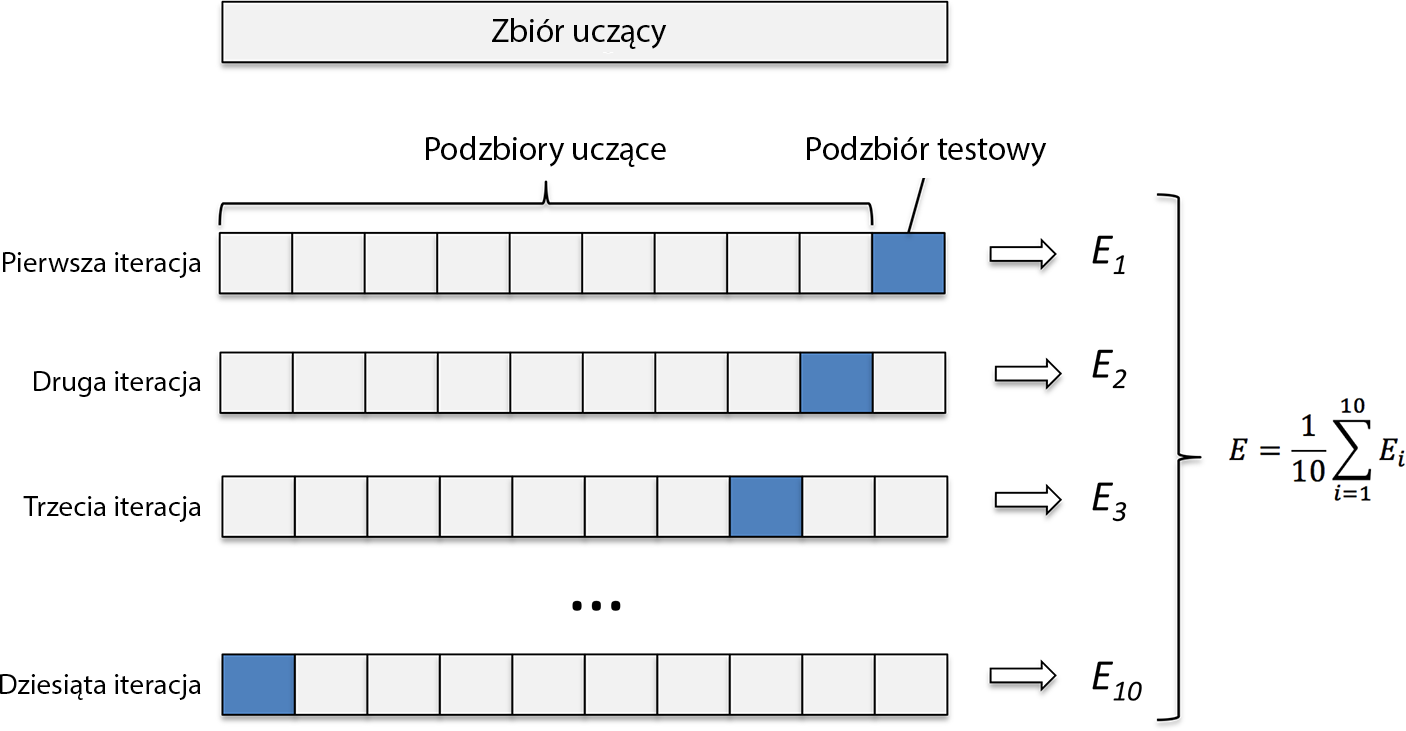
</div>

Rzetelne oszacowanie miary uzyskujemy uśredniając wyniki ze wszystkich $k$ foldów. W ten sposób gwarantujemy, że modele są zawsze oceniane na zbiorze, który nie był użyty do treningu a dodatkowo każdy przypadek został też użyty do testowania w jednym z foldów.

Wykorzystajmy obiekt klasy `KFold`, który umożliwia podział danych na zestawy danych używane w walidacji krzyżowej. Wykonajmy dla danych Iris 3-krotną kroswalidację.

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

kf = KFold(n_splits=3)

scores = []

for fold_no, (train_idx, test_idx) in enumerate(kf.split(X=iris.data, y = iris.target)):
    X_train = iris.data[train_idx]
    X_test  = iris.data[test_idx]
    Y_train = iris.target[train_idx]
    Y_test  = iris.target[test_idx]
    clf.fit(X_train, Y_train)
    Y_pred = clf.predict(X_test)
    score = accuracy_score(Y_test, Y_pred)
    scores.append(score)
    print('Fold: %2d, Rozkład w klasach.: %s, Poprawność: %.3f' % (fold_no+1,
          np.bincount(iris.target[train_idx]), score))
    
    


Dlaczego w każdym foldzie wyszła poprawność zero? Podzieliliśmy zbiór na trzy podzbiory. Początkowo miał on 150 egzemplarzy a w każdej klasie było 50 egzemplarzy. W związku z czym podzieliliśmy zbiór danych w taki sposób, że trenowaliśmy klasyfikator na dwu kwiatach a testowaliśmy go na trzecim. Nie daliśmy zatem żadnych szans w naszej ewaluacji w teście. Rozkład przypadków w klasach dobitnie to obrazuje. 

Moglibyśmy po prostu wymieszać zbiór wejściowy tak aby dla kolejnych foldów wybierane były losowe podzbiory. 
Jednak lepszym sposobem jest zastosowanie losowania warstwowego (_Stratified Sampling_), które podczas podziału danych stara się zachować proporcje w liczbie przypadków z różnych klas. Ma to istotne znaczenie w przypadku niezbalansowanch danych.

> Niezbalansowane zbiory danych (czyli takie, w których mamy znacząco różne wielkości w różnych klasach) wymagają specjalnego traktowania


Podział danych z zachowaniem balansu klas w `scikit-learn` realizowany jest za pomocą `StratifiedKFold`

In [ ]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=3)

scores = []
for fold_no, (train_idx, test_idx) in enumerate(kf.split(X=iris.data, y = iris.target)):
    X_train = iris.data[train_idx]
    X_test = iris.data[test_idx]
    Y_train = iris.target[train_idx]
    Y_test = iris.target[test_idx]
    clf.fit(X_train, Y_train)
    Y_pred = clf.predict(X_test)
    score = accuracy_score(Y_test, Y_pred)
    scores.append(score)
    print('Fold: %2d, Rozkład klas.: %s, Poprawność: %.3f' % (fold_no+1,
          np.bincount(iris.target[train_idx]), score))

print('\nŚrednia poprawność CV : %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Oczywiście na powyższy kod istnieje funkcja pomocnicza, za pomocą której całą procedurę CV uruchomimy jedną instrukcją `cross_val_score`. Użycie tej funkcji wymaga utworzenia obiektu oceniającego poprawność modelu w każdym z foldów. Służy do tego funkcja `make_scorer`, która na poniższym fragmencie kodu opakowuje wywołanie funkcji `accuracy_score`

In [ ]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

accuracy_scorer = make_scorer(accuracy_score)

scores = cross_val_score(clf, iris.data, y=iris.target, cv=10, scoring=accuracy_scorer)

for i, score in enumerate(scores):
    print('Fold %d, Poprawność: %.3f' % (i+1, score))

print('\nŚrednia poprawność CV : %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))


## Kolejka czynności

W przypadku niektórych metod klasyfikacji dane wejściowe powinny mieścić się w odpowiednich zakresach wartości. W tym celu już wcześniej stosowaliśmy standaryzację. W przypadku podziału na dane treningowe i testowe nie możemy dokonać na tych zbiorach osobnej standaryzacji, gdyż mogą one posiadać różne wartości średnie i różne odchylenia. Standaryzacja powinna być wykonana na zbiorze treningowym a następnie wartości średnie oraz odchylenia uzyskane podczas tej transformacji mogą być użyte do przeskalowania danych testowych. W ten sposób oba zbiory danych podlegają tej samej transformacji liniowej a ich rozkłady pozostają spójne. 
W `scikit-learn` istnieje możliwość zdefiniowania potoku (_pipe_) składającego się z ciągu transformacji (np. standaryzacji) zakończonych modelem predykcyjnym (np. drzewem decyzyjnym). Taki potok też jest modelem predykcyjnym, gdyż udostępnia metody `fit()` oraz `predict()` i może być traktowana jako nowy model klasyfikujący a wstępna transformacja jest jego integralną częścią składową. Gdy dokonamy dopasowania `fit()` wówczas ostateczny model zostanie dopasowany na danych, które zostały przetworzone przez wszystkie poprzedzające w potoku transformacje. Z kolei, gdy uruchomimy predykcję `predict()` na zbiorze testowym, to zbiór ten zostanie automatycznie przetworzony przez wszystkie transformacje z potoku, które wcześniej zostały dopasowane na danych treningowych. 

Poniższy obrazek pokazuje jak wygląda procedura dopasowania na zbiorze treningowym i procedura predykcji na zbiorze testowym potoku zawierającego dwie sekwencyjnie wykonywane transformacje danych wejściowych (skalowanie `Scaling` i redukcję wymiarowości `Dimensionality reduction`) oraz model predykcyjny na końcu kolejki.

<div>
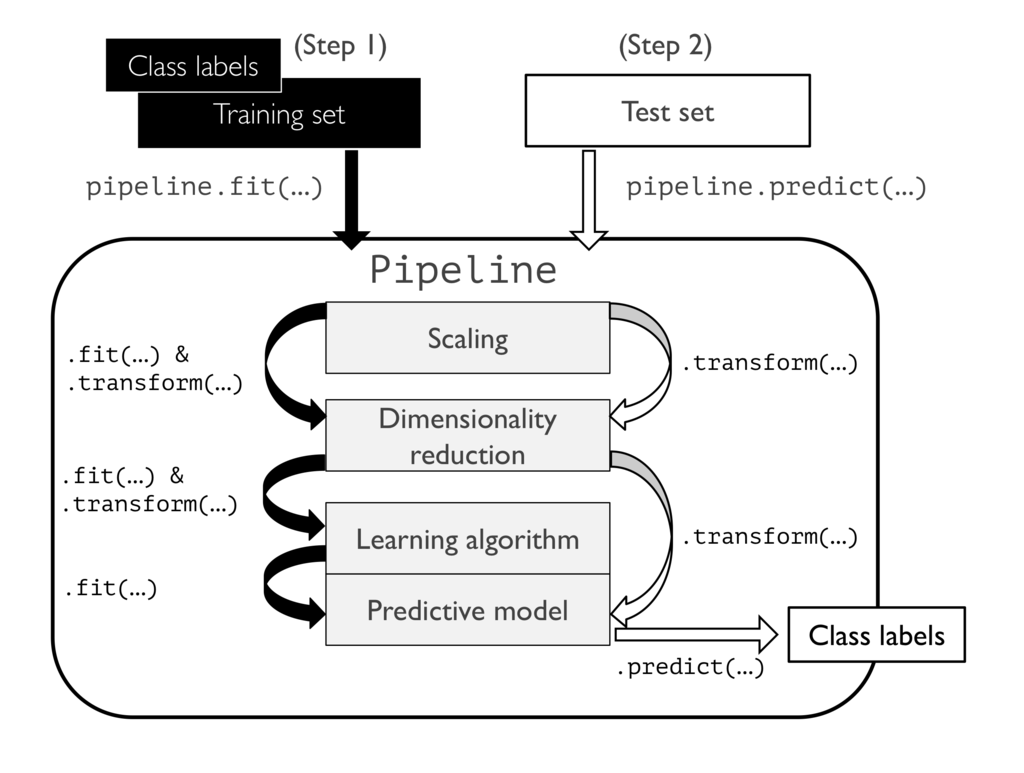
</div>

Spróbujmy utworzyć potok składający się ze standaryzacji oraz klasyfikatora kNN. 
Standaryzacja realizowana jest za pomocą obiektu `StandardScaler`.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.3, random_state=0)

pipe_knn = make_pipeline(StandardScaler(), KNeighborsClassifier())

# dopasowanie modelu składającego się z sekwencji standaryzacja + kNN
pipe_knn.fit(X_train, y_train)

# predykcja na danych testowych
y_pred = pipe_knn.predict(X_test)

print('Poprawność klasyfikacji: %.3f' % pipe_knn.score(X_test, y_test))

Klasyfikator kNN jest czuły na zakresy zmiennych, gdyż wyznacza odległości między przypadkami. Dlatego robiąc walidację krzyżową w celu oceny skuteczności klasyfikatora kNN powinniśmy dokonać osobnej standaryzacji podzbiorów treningowych w każdym foldzie. Używając kolejki aktywności (potoku)  cała procedura oceny modelu ze wstępną standaryzacją danych zostanie wykonana automatycznie.

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
    
kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)

scores = []
for k, (train, test) in enumerate(kfold):
    pipe_knn.fit(X_train[train], y_train[train])
    score = pipe_knn.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %2d, Rozkład klass.: %s, Poprawność: %.3f' % (k+1,
          np.bincount(y_train[train]), score))
    
print('\nŚrednia poprawność CV: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

## Strojenie parametrów z pomocą przeszukiwania siatką

Procedura walidacji krzyżowej daje rzetelną ocenę generalizacji modeu, czyli poprawności działania modelu na nieznanych danych. Możemy więc wykorzystać ją do poszukiwania takich parametrów konfiguracji modelu, które zapewnią najlepszy wynik na interesujących nas danych.
Przykładowo moglibyśmy wyznaczyć optymalną głębokość drzewa decyzji dla zbioru Iris powtarzając kroswaliację z różnymi parametrami `max_depth`. Pakiet `scikit-learn` zawiera obiekt `GridSearchCV`, który pozwala zautomatyzować proces strojenia parametrów z użyciem walidacji krzyżowej. Uruchamia on walidację krzyżową dla danego modelu wielokrotnie z użyciem wszystkich kombinacji parametrów zdefiniowanych w słowniku przekazanym w argumencie `param_grid`. 

Zobaczmy w jaki sposób możemy spróbować dostroić głębokość drzewa dla danych Iris

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=1)

param_grid = [ {'max_depth': [ 1, 2, 3, 5 ] } ]

gs = GridSearchCV(estimator=tree, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10)


gs = gs.fit(iris.data, iris.target)

Metoda `fit()` uruchomi 4 razy 10-cio krotną (`cv=10`) walidację krzyżową drzewa decyzyjnego. W każdej kroswalidacji parametr  `max_depth` drzewa otrzyma  kolejną  wartością z listy  `[ 1, 2, 3, 5 ]`. Na podstawie uzyskanych wyników poprawności klasyfikacji tworzony jest ranking 4 drzew decyzyjnych i ostatecznie możemy uzyskać najlepszy zestaw parametrów.

In [ ]:
print('Największa poprawność: %.3f' % gs.best_score_)
print('Najlepszy zestaw parametrów: %s' % str(gs.best_params_))

Pole `cv_results_` zawiera szczegółowe wyniki procedury szukania siatką wraz z ostatecznym rankingiem klasyfikatorów.
Dane umieszczone są w słowniku, który idealnie nadaje się do zainicjowania tabeli `DataFrame`. Każdy wiersz zawiera wyniki dla innej wartości parametru `max_depth`.

In [ ]:
import pandas as pd

df = pd.DataFrame(gs.cv_results_)
df


Procedura przeszukiwania siatką pozwala na jednoczesne strojenie większej liczby parametrów, dla każdego parametru określamy też zakres przeszukiwanych wartości. Wówczas procedura tworzy ranking modeli zbudowanych dla wszystkich możliwych kombinacji zadanych wartości parametrów.
W poniższym przykładzie przeprowadzona zostanie 4 krotna procedura walidacji krzyżowej oceniająca model dla 
wszystkich zdefiniowanych kombinacji parametru `kernel` oraz `C`.

In [ ]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV

iris = datasets.load_iris()
parameters = {'kernel': ['linear', 'rbf'], 'C':[ 1, 10]}
svc = svm.SVC()

gs = GridSearchCV(estimator=svc, param_grid=parameters, cv=10, scoring='accuracy')
gs.fit(iris.data, iris.target)


print('Największa poprawność: %.3f' % gs.best_score_)
print('Najlepszy zestaw parametrów: %s' % str(gs.best_params_))

df = pd.DataFrame(gs.cv_results_)
df


Klasyfikator SVM lepiej się zachowuje, gdy dane są wystandaryzowane. Jeżeli uruchomienie porządniej komórki notatnika zakończyło się serią komunikatów z ostrzeżeniem (może to zależeć od wersji pakietu scikit-learn) to właśnie efekt użycia do treningu SVMa danych, które nie zostały odpowiednio przeskalowane.
Stwórzmy więc kolejkę, która powiąże klasyfikator SVM z transformację `StandardScaler()` i powtórzmy strojenie parametrów za pomocą przeszukiwania siatką CV

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state=1))

Ponieważ model SVM stanowi teraz część składową modelu `pipe_svc` to nie mamy bezpośredniego dostępu do parametrów `C` i `kernel`. 
Jednak obiekt kolejki `pipe_scv` udostępnia parametry wszystkich modeli składowych za pomocą metody `get_params()`. Zobaczmy listę dostępnych parametrów.

In [ ]:
for p in pipe_svc.get_params():
    print(p)

Widać, że parametr `C` modelu SVM jest mapowany tutaj pod nazwą `svc__C` a nazwa funkcji jądrowej pod nazwą `svc__kernel`. Te nazwy posłużą nam do zdefiniowania strategi przeszukiwania  parametrów modelu SVM określonej w argumencie ``param_grid`` przeszukiwania siatką.

In [ ]:
param_range = [0.001, 0.01, 0.1, 0.1, 1.0, 10.0, 100.0]

param_grid = [{'svc__C': param_range, 
               'svc__kernel': ['linear' , 'rbf']}]

gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='accuracy',
                  refit=True,
                  cv=10)

gs = gs.fit(iris.data, iris.target)

print('Największa poprawność: %.3f' % gs.best_score_)
print('Najlepszy zestaw parametrów: %s' % str(gs.best_params_))

df = pd.DataFrame(gs.cv_results_)
df

Najlepszy z rankingu zestaw parametrów tworzy konfigurację modelu, która jest dostępna w polu `best_estimator`. Możemy użyć go teraz do treningu na całym zbiorze treningowym i użyć na nowych danych do predykcji nieznanych przypadków. Jeżeli w wyszukiwaniu użyliśmy `refit=True` to najlepszy model zostanie automatycznie wytrenowany na całym zbiorze treningowym i jest gotowy do użycia na nowych danych.

In [ ]:
clf = gs.best_estimator_

# najlepszy model możemy teraz wytrenować na całym dostępnym zbiorze danych aby uzyskać końcowy model z najlepszymi parametrami dla danych Iris
# jeżeli ustawiliśmy w wyszukiwaniu refit=True, to poniższa instrukcja jest już niepotrzebna
best_model = clf.fit(iris.data, iris.target) 


## Zadanie: klasyfikacja zbioru Wisconsin Diagnostic Breast Cancer

Wczytaj zbiór danych dostępny pod adresem https://www.fizyka.umk.pl/~grochu/wdm/files/wdbc_train.data
Plik zawiera wyniki badan 455 pacjentów z rakiem piersi. Każdy przypadek opisany jest 30 ciągłymi atrybutami. Pierwsza kolumna zawiera informacje o klasie: wartość 0 to grupa nowotworów łagodnych (`malignat`), wartość 1 to nowotwory złośliwe (`benign`). Wszystkie wartości liczbowe oddzielone są przecinkami a plik jest zgodny z formatem CSV.

1. Wykorzystaj mechanizm przeszukiwania siatki (GridSearchCV) w celu dostrojenia parametrów wybranego klasyfikatora tak aby uzyskać model zapewniający jak najlepszy poziom klasyfikacji danych `wdbc_train.data`. 
Strojenie parametrów dokonaj dla JEDNEGO z 3 wymienionych niżej klasyfikatorów sprawdzając wszystkie kombinacje podanych parametrów.
  1. Drzewo decyzyjne z parametrami:
      - `max_depth`: maksymalna głębokość drzewa z zakresu od 1 do 10
      - `criterion`: kryterium podziału zmiennych, sprawdź kryterium `'gini'` i `'entropy'`
  2. Metoda k najbliższych sąsiadów z parametrami:
      - `n_neighbors`: liczba najbliższych sąsiadów `[ 1, 3, 5, 7, 11 ]`
      - `metric`:  metryka użyta do pomiaru odległości, sprawdź metryki `'euclidean'` i `'chebyshev'`
  3. SVM z Gaussowską funkcją jądrową (`kernel='rbf'`):
     - `C`: współczynnik regularyzacji, szukane wartości  `[0.01, 0.1, 1.0, 10.0]`
     - `gamma`: szerokość funkcji Gaussa, szukane wartości  `[0.01, 0.1, 1.0, 10.0]`

Uwaga: klasyfikator kNN oraz SVM są czułe na zakres zmiennych i wskazane jest zastosowanie standaryzacji danych treningowych.

2. Korzystając z najlepszego znalezionego modelu wytrenowanego na całym zbiorze `wdbc_train.data` przeprowadź klasyfikację przypadków znajdujących się w pliku: https://www.fizyka.umk.pl/~grochu/wdm/files/wdbc_test.data
Wyznacz macierz konfuzji oraz wartości precyzji, recall i miary F1 dla klasy nowotworów złośliwych (wartość 1).


3. (Zadanie tylko dla chętnych): Zbiór danych `wdbc` nie jest zbalansowany. Przypadki złośliwe stanowią 37% danych. Dodatkowo, zależy nam na tym aby jak najbardziej zminimalizować ryzyko zaklasyfikowania złośliwego przypadku jako łagodnego. Zamiast poprawności klasyfikacji zastosuj  metrykę F1 do oceny klasyfikatora w procedurze strojenia parametrów, gdzie klasa złośliwych nowotworów (1) stanowi przypadki pozytywne. Rozszerz też zakres wartości i liczbę dostrajanych parametrów wedłóg własnego uznania tak aby znaleźć jak najlepszy model klasyfikacji danych `wdbc`. 



